In [ ]:
!pip install numpy matplotlib pillow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading image: corrected_pre_dither.png
Image Size: (1804, 1804)
Loading noise: ..\bluenoise\128_128\LDR_LLL1_0.png


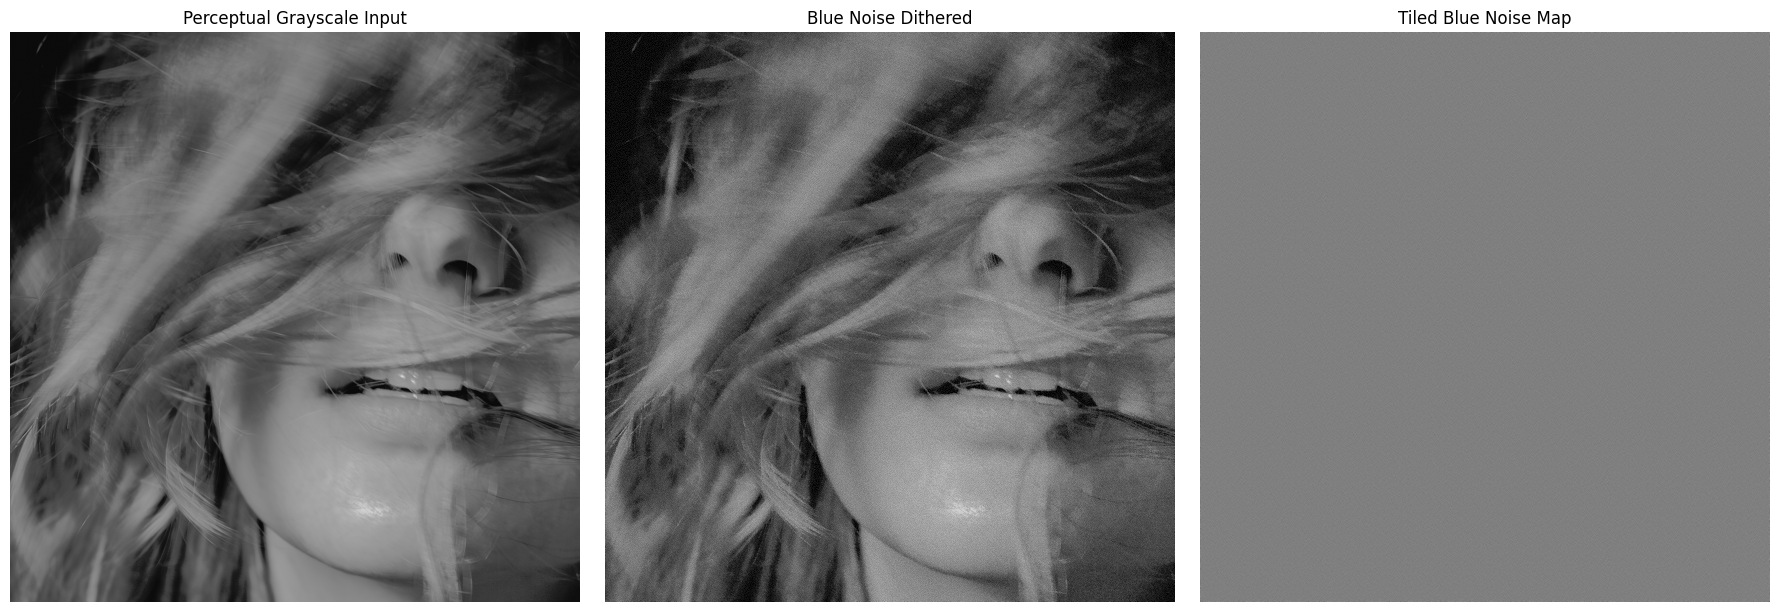

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# ==========================================
# 1. Configuration & Paths
# ==========================================
# Adjust these paths as needed
INPUT_IMAGE_PATH = "corrected_pre_dither.png"

# Using os.path.join for cross-platform compatibility (Windows/Mac/Linux)
# This matches your request: ..\bluenoise\128_128\LDR_LLL1_0.png
BLUE_NOISE_PATH = os.path.join('..', 'bluenoise', '128_128', 'LDR_LLL1_0.png')

# ==========================================
# 2. Helper Functions
# ==========================================

def load_and_normalize(path):
    """Loads an image, converts to float, normalizes to 0-1."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    
    img = Image.open(path)
    img = img.convert('RGB') # Ensure RGB
    return np.array(img).astype(np.float32) / 255.0

def rgb_to_grayscale_perceptual(img_rgb):
    """
    Converts RGB to Grayscale using Rec. 601 Luma coefficients.
    L = 0.299*R + 0.587*G + 0.114*B
    """
    # img_rgb shape is (H, W, 3)
    r = img_rgb[:, :, 0]
    g = img_rgb[:, :, 1]
    b = img_rgb[:, :, 2]
    
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray

def tile_noise(noise_texture, target_shape):
    """
    Tiles the noise texture to cover the target image shape.
    target_shape: (Height, Width)
    """
    th, tw = target_shape
    nh, nw = noise_texture.shape
    
    # Calculate how many times to repeat in Y and X
    repeat_y = (th // nh) + 1
    repeat_x = (tw // nw) + 1
    
    # Tile and crop to exact size
    tiled = np.tile(noise_texture, (repeat_y, repeat_x))
    return tiled[:th, :tw]

# ==========================================
# 3. Main Logic
# ==========================================

try:
    # A. Load Input Image
    print(f"Loading image: {INPUT_IMAGE_PATH}")
    img_rgb = load_and_normalize(INPUT_IMAGE_PATH)
    
    # B. Convert to Grayscale Perceptually
    img_gray = rgb_to_grayscale_perceptual(img_rgb)
    print(f"Image Size: {img_gray.shape}")

    # C. Load Blue Noise Texture
    print(f"Loading noise: {BLUE_NOISE_PATH}")
    # Load noise, convert to grayscale (L), normalize 0-1
    noise_img = Image.open(BLUE_NOISE_PATH).convert('L')
    noise_arr = np.array(noise_img).astype(np.float32) / 255.0
    
    # D. Tile the Noise to match Image Size
    noise_tiled = tile_noise(noise_arr, img_gray.shape)

    power_levels = np.array([0.0, 0.0, 0.8, 1.0], dtype=np.float32)

    # 2. Convert Image Brightness to Target Laser Power
    # Assuming img_gray: 1.0 = White (Paper), 0.0 = Black (Ink)
    # We invert this because for the laser: 0.0 = Off (Paper), 1.0 = On (Burn)
    target_power = img_gray
    
    # Ensure range is strictly 0-1
    target_power = np.clip(target_power, 0.0, 1.0)

    # 3. Find the Lower and Upper bounds for every pixel
    # We find which interval of power_levels the current pixel falls into.
    # np.searchsorted finds the insertion index to maintain order.
    # We subtract 1 to get the index of the "step below".
    idx = np.searchsorted(power_levels, target_power, side='right') - 1
    
    # Clamp indices to ensure we don't go out of bounds
    idx = np.clip(idx, 0, len(power_levels) - 2)

    lower_step = power_levels[idx]
    upper_step = power_levels[idx + 1]

    # 4. Normalize the pixel value within its specific step interval
    # Example: If pixel wants 0.7 power, it sits between 0.5 and 0.9.
    # The normalized value (0.0 to 1.0) represents how close it is to the upper step.
    step_range = upper_step - lower_step
    
    # Handle case where step_range is 0 to avoid division by zero
    step_range[step_range == 0] = 1.0 
    
    normalized_val = (target_power - lower_step) / step_range

    # 5. Apply the Blue Noise Threshold
    # If the normalized value is higher than the noise, bump up to the upper step.
    # Otherwise, stay at the lower step.
    step_up_mask = normalized_val > noise_tiled
    
    dithered_output = np.where(step_up_mask, upper_step, lower_step)

    # Output is now an array containing only [0.0, 0.5, 0.9, 1.0]

    # ==========================================
    # 4. Visualization
    # ==========================================
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original Grayscale
    ax[0].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    ax[0].set_title("Perceptual Grayscale Input")
    ax[0].axis('off')

    # Dithered Result
    ax[1].imshow(dithered_output, cmap='gray', vmin=0, vmax=1)
    ax[1].set_title("Blue Noise Dithered")
    ax[1].axis('off')

    # The Noise Mask (Zoomed in snippet for visualization)
    ax[2].imshow(noise_tiled, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title("Tiled Blue Noise Map")
    ax[2].axis('off')


    plt.tight_layout()
    plt.show()

    # Optional: Save result
    Image.fromarray((dithered_output * 255).astype(np.uint8)).save('output_dither.png')

except Exception as e:
    print(f"Error: {e}")
    print("Ensure 'xyz.png' exists and the blue noise path is correct.")

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import os
from scipy import interpolate, sparse
from scipy.sparse.linalg import spsolve
from scipy.ndimage import convolve

# ==========================================
# 1. Configuration
# ==========================================
INPUT_IMAGE_PATH = "../posters/festung1.png"

# Using os.path.join for cross-platform compatibility (Windows/Mac/Linux)
# This matches your request: ..\bluenoise\128_128\LDR_LLL1_0.png
BLUE_NOISE_PATH = os.path.join('..', 'bluenoise', '128_128', 'LDR_LLL1_0.png')
LASER_STEPS = 4
MAX_LASERPOWER = 75
POWER_LEVELS = np.array([0,65,70,75], dtype=np.float32)

# --- ADAPTIVE SPREAD SETTINGS ---

avoid_peaks=True,
peak_avoidance_strength=0.2
hysteresis_enabled=True
hysteresis_strength=0.8

# Small spread for highlights (detail), Large spread for shadows (contrast/bleed control)
MIN_SPREAD = 2
MAX_SPREAD = 2

GAMMA = 2.2 # Set your desired value
LOGCOMPRESS = 1
LOGEXPAND = 1
SHARPEN_AMOUNT = 1.4

# Sizing Settings
TARGET_DPI = 254
TARGET_LONGEST_EDGE_MM = 170  # Set the desired length of the longest side in mm
runout_mm = 2.0

#correction_df = pd.read_csv("../luts/uv_laser_correction_raw.csv")

correction_df = pd.read_csv("cyanotype_lut.csv")

####################
# DeepSeek
####################

def create_cyanotype_spread_profile(lut, LASER_STEPS=None):
    """
    Create spread profile optimized for cyanotype characteristics.
    """
    if LASER_STEPS is not None:
        num_levels = LASER_STEPS
    else:
        num_levels = len(lut)
    
    # Resample LUT to match num_levels if needed
    if len(lut) != num_levels:
        original_indices = np.linspace(0, 1, len(lut))
        new_indices = np.linspace(0, 1, num_levels)
        lut_resampled = np.interp(new_indices, original_indices, lut)
    else:
        lut_resampled = lut
    
    # Calculate derivative to understand sensitivity
    derivative = np.gradient(lut_resampled)
    abs_derivative = np.abs(derivative)
    
    # Normalize derivative
    if abs_derivative.max() > abs_derivative.min():
        der_norm = (abs_derivative - abs_derivative.min()) / (abs_derivative.max() - abs_derivative.min())
    else:
        der_norm = np.zeros_like(abs_derivative)
    
    # Create spread profile
    spread_profile = np.ones(num_levels, dtype=int)
    
    # In sensitive regions (steep slope), use smaller spread
    sensitive_mask = der_norm > 0.85
    spread_profile[sensitive_mask] = 4  # Minimal spread
    
    # In moderately sensitive regions
    moderate_mask = (der_norm > 0.3) & (der_norm <= 0.85)
    spread_profile[moderate_mask] = 8
    
    # In flat regions, use larger spread
    flat_mask = der_norm <= 0.3
    spread_profile[flat_mask] = 12
    
    # In very flat regions (extremes)
    very_flat_mask = der_norm <= 0.05
    spread_profile[very_flat_mask] = 8
    
    # Ensure spread is at least 1
    spread_profile = np.maximum(spread_profile, 1)
    
    # Smooth the spread profile to avoid abrupt changes
    spread_profile = convolve(spread_profile.astype(float), np.ones(3)/3, mode='nearest').astype(int)
    
    return spread_profile


def identify_problematic_regions(lut):
    """
    Identify non-monotonic and overly sensitive regions in the LUT.
    """
    # Calculate derivative (sensitivity)
    derivative = np.gradient(lut)
    
    # Find non-monotonic regions (where derivative changes sign)
    # Note: diff reduces size by 1, so non_monotonic has len(lut)-1 elements
    sign_changes = np.diff(np.sign(derivative)) != 0
    
    # Find overly sensitive regions (steep slopes)
    # Normalize derivative magnitude
    if len(lut) > 0:
        abs_derivative = np.abs(derivative)
        if abs_derivative.max() > 0:
            der_norm = abs_derivative / abs_derivative.max()
            sensitive_regions = der_norm > 0.1
        else:
            sensitive_regions = np.zeros_like(derivative, dtype=bool)
    else:
        sensitive_regions = np.zeros_like(derivative, dtype=bool)
    
    # Find flat regions (insensitive)
    flat_regions = np.abs(derivative) < 0.001
    
    return {
        'non_monotonic': sign_changes,  # Length is len(lut)-1
        'sensitive': sensitive_regions, # Length is len(lut)
        'flat': flat_regions,           # Length is len(lut)
        'derivative': derivative        # Length is len(lut)
    }


def cyanotype_adaptive_threshold(fraction, lower_bound, upper_bound, gap,
                                lut, problem_regions,
                                avoid_peaks=True, avoidance_strength=0.8):
    """
    Create threshold specifically optimized for cyanotype characteristics.
    """
    threshold = np.zeros_like(fraction)
    mask = gap > 0
    
    if not np.any(mask):
        return threshold
    
    f = fraction[mask]
    lb = lower_bound[mask].astype(int)  # Convert to int here
    ub = upper_bound[mask].astype(int)  # Convert to int here
    g = gap[mask]
    
    # Base threshold shape
    base_threshold = f.copy()
    
    # Adjust for non-monotonic regions
    if avoid_peaks:
        for i in range(len(lb)):
            # Check the range between lower and upper bound
            idx_start = lb[i]
            idx_end = ub[i]
            
            # Ensure indices are within bounds
            if idx_end >= len(lut):
                idx_end = len(lut) - 1
            if idx_start < 0:
                idx_start = 0
            
            # Check if any indices in this range are in non-monotonic region
            if idx_start <= idx_end and idx_start < len(problem_regions['non_monotonic']):
                idx_end_nm = min(idx_end, len(problem_regions['non_monotonic']) - 1)
                if idx_end_nm >= idx_start:
                    idx_range = np.arange(idx_start, idx_end_nm + 1)
                    if np.any(problem_regions['non_monotonic'][idx_range]):
                        # This range contains problematic region
                        lower_val = lut[lb[i]] if lb[i] < len(lut) else lut[-1]
                        upper_val = lut[ub[i]] if ub[i] < len(lut) else lut[-1]
                        
                        # If the curve is non-monotonic, prefer the value that's
                        # on the descending side (assuming it's more stable)
                        if lower_val < upper_val:
                            # Increasing region - bias toward upper bound
                            base_threshold[i] = base_threshold[i] * (1 - avoidance_strength) + avoidance_strength
                        else:
                            # Decreasing region - bias toward lower bound
                            base_threshold[i] = base_threshold[i] * (1 - avoidance_strength)
    
    # Adjust for sensitivity
    # In sensitive regions, we want more conservative dithering
    for i in range(len(lb)):
        idx_start = lb[i]
        idx_end = ub[i]
        
        # Ensure indices are within bounds
        if idx_end >= len(lut):
            idx_end = len(lut) - 1
        if idx_start < 0:
            idx_start = 0
        
        if idx_end >= idx_start and idx_end < len(problem_regions['derivative']):
            idx_range = np.arange(idx_start, min(idx_end, len(problem_regions['derivative']) - 1) + 1)
            if len(idx_range) > 0:
                avg_sensitivity = np.mean(np.abs(problem_regions['derivative'][idx_range]))
                if avg_sensitivity > 0.03:  # Highly sensitive
                    # Flatten threshold in middle to avoid extremes
                    dist_from_middle = np.abs(f[i] - 0.5)
                    flattening = 0.7 * (1 - dist_from_middle)
                    base_threshold[i] = 0.5 + (base_threshold[i] - 0.5) * (1 - flattening)
    
    threshold[mask] = base_threshold
    return threshold


def calculate_stability_factor(lower_bound, upper_bound, lut, problem_regions):
    """
    Calculate how much to trust blue noise vs adaptive threshold.
    More trust in stable regions, less in problematic ones.
    """
    h, w = lower_bound.shape
    stability = np.ones((h, w), dtype=float)
    
    # Convert to flat arrays for processing
    lb_flat = lower_bound.ravel().astype(int)
    ub_flat = upper_bound.ravel().astype(int)
    stability_flat = stability.ravel()
    
    for i in range(len(lb_flat)):
        idx_start = lb_flat[i]
        idx_end = ub_flat[i]
        
        # Ensure indices are within bounds
        if idx_end >= len(lut):
            idx_end = len(lut) - 1
        if idx_start < 0:
            idx_start = 0
        
        if idx_end >= idx_start:
            # Check for non-monotonic regions
            idx_range_nm = np.arange(idx_start, min(idx_end, len(problem_regions['non_monotonic']) - 1) + 1)
            if len(idx_range_nm) > 0 and np.any(problem_regions['non_monotonic'][idx_range_nm]):
                stability_flat[i] = 0.4  # Low trust in blue noise
            
            # Check sensitivity
            idx_range_der = np.arange(idx_start, min(idx_end, len(problem_regions['derivative']) - 1) + 1)
            if len(idx_range_der) > 0:
                avg_sensitivity = np.mean(np.abs(problem_regions['derivative'][idx_range_der]))
                if avg_sensitivity > 0.08:
                    stability_flat[i] *= 0.6  # Reduce trust in sensitive regions
    
    # Reshape back to 2D
    stability = stability_flat.reshape((h, w))
    return np.clip(stability, 0.1, 1.0)


def apply_hysteresis_simple(adaptive_threshold, fraction, lower_bound, current_gap,
                           hysteresis_strength=0.15):
    """
    Simple hysteresis that only considers immediate left and above neighbors.
    Fast and effective for most cases.
    """
    if hysteresis_strength <= 0:
        return adaptive_threshold
    
    h, w = fraction.shape
    result = adaptive_threshold.copy()
    
    # Pre-compute decisions for all pixels
    decisions = (fraction > adaptive_threshold).astype(float)
    
    # Apply hysteresis scanline by scanline
    for i in range(h):
        for j in range(w):
            if current_gap[i, j] > 0:
                current_decision = decisions[i, j]
                
                # Check left neighbor (if exists)
                left_influence = 0
                if j > 0 and current_gap[i, j - 1] > 0:
                    left_decision = decisions[i, j - 1]
                    # Weight decreases with distance
                    left_influence = (left_decision - 0.5) * hysteresis_strength * 0.7
                
                # Check above neighbor (if exists)
                above_influence = 0
                if i > 0 and current_gap[i - 1, j] > 0:
                    above_decision = decisions[i - 1, j]
                    above_influence = (above_decision - 0.5) * hysteresis_strength * 0.7
                
                # Check diagonal above-left (if exists)
                diag_influence = 0
                if i > 0 and j > 0 and current_gap[i - 1, j - 1] > 0:
                    diag_decision = decisions[i - 1, j - 1]
                    diag_influence = (diag_decision - 0.5) * hysteresis_strength * 0.3
                
                # Total influence
                total_influence = left_influence + above_influence + diag_influence
                
                # Adjust threshold
                result[i, j] = adaptive_threshold[i, j] - total_influence
                
                # Clamp to reasonable bounds
                original = adaptive_threshold[i, j]
                min_val = max(0.0, original - hysteresis_strength * 1.5)
                max_val = min(1.0, original + hysteresis_strength * 1.5)
                result[i, j] = np.clip(result[i, j], min_val, max_val)
    
    return result


def cyanotype_adaptive_dither_with_hysteresis(img, noise, compensated_lut, spread_profile,
                                             avoid_peaks=True, peak_avoidance_strength=0.8,
                                             hysteresis_enabled=True, hysteresis_strength=0.15):
    """
    Complete cyanotype dithering with hysteresis support.
    """
    h, w = img.shape
    
    target_density = 1.0 - img 
    
    lut_size = len(compensated_lut)
    max_idx = lut_size - 1
    
    # 1. Calculate the ideal floating point index
    idx_float = target_density * max_idx
    
    # 2. Determine Adaptive Spread per pixel
    spread_profile_len = len(spread_profile)
    spread_indices = (target_density * (spread_profile_len - 1)).astype(int)
    pixel_spreads = spread_profile[spread_indices]
    
    # 3. Calculate Lower Bound
    lower_bound = (np.floor(idx_float / pixel_spreads) * pixel_spreads).astype(int)
    
    # 4. Calculate Upper Bound
    upper_bound = np.clip(lower_bound + pixel_spreads, 0, max_idx).astype(int)

    # 5. Calculate Actual Gap
    current_gap = upper_bound - lower_bound
    
    # 6. Calculate Dither Fraction
    fraction = np.zeros_like(idx_float)
    mask = current_gap > 0
    fraction[mask] = (idx_float[mask] - lower_bound[mask]) / current_gap[mask]
    
    # 7. Identify problematic regions
    problem_regions = identify_problematic_regions(compensated_lut)
    
    # 8. Create adaptive threshold
    adaptive_threshold = cyanotype_adaptive_threshold(
        fraction, lower_bound, upper_bound, current_gap, 
        compensated_lut, problem_regions,
        avoid_peaks, peak_avoidance_strength
    )
    
    # 9. Apply hysteresis if enabled
    if hysteresis_enabled:
        adaptive_threshold = apply_hysteresis_simple(
            adaptive_threshold, fraction, lower_bound, current_gap,
            hysteresis_strength=hysteresis_strength
        )
    
    # 10. Blend with blue noise
    stability_factor = calculate_stability_factor(lower_bound, upper_bound, 
                                                 compensated_lut, problem_regions)
    blended_threshold = stability_factor * noise + (1 - stability_factor) * adaptive_threshold
    
    # 11. Compare to threshold
    bump_up = (fraction > blended_threshold).astype(int)
    
    # 12. Select Final Index
    final_density_idx = lower_bound + (bump_up * current_gap)
    
    # 13. Ensure final indices are within bounds
    final_density_idx = np.clip(final_density_idx, 0, max_idx)
    
    # 14. Map to Laser Power
    final_laser_power = compensated_lut[final_density_idx]
    
    # Convert to machine steps
    machine_steps = (final_laser_power * (LASER_STEPS - 1)).astype(int)
    
    return machine_steps


# Much simpler version - use this one if the above is still having issues
def cyanotype_simple_adaptive(img, noise, compensated_lut, spread_profile,
                             edge_bias=0.3, middle_flatness=0.5):
    """
    Simple adaptive dithering for cyanotype - robust and fast.
    """
    h, w = img.shape
    
    target_density = 1.0 - img 
    
    lut_size = len(compensated_lut)
    max_idx = lut_size - 1
    
    # 1. Calculate the ideal floating point index
    idx_float = target_density * max_idx
    
    # 2. Determine Adaptive Spread per pixel
    spread_profile_len = len(spread_profile)
    spread_indices = (target_density * (spread_profile_len - 1)).astype(int)
    pixel_spreads = spread_profile[spread_indices]
    
    # 3. Calculate Lower Bound
    lower_bound = (np.floor(idx_float / pixel_spreads) * pixel_spreads).astype(int)
    
    # 4. Calculate Upper Bound
    upper_bound = np.clip(lower_bound + pixel_spreads, 0, max_idx).astype(int)

    # 5. Calculate Actual Gap
    current_gap = upper_bound - lower_bound
    
    # 6. Calculate Dither Fraction
    fraction = np.zeros_like(idx_float)
    mask = current_gap > 0
    fraction[mask] = (idx_float[mask] - lower_bound[mask]) / current_gap[mask]
    
    # 7. Simple adaptive threshold using vectorized operations
    adaptive_threshold = np.zeros_like(fraction)
    
    # Create a smooth threshold function
    # When fraction is near 0 or 1, bias toward edges
    # When fraction is near 0.5, use more balanced threshold
    f_valid = fraction[mask]
    
    # Distance from middle (0 at edges, 1 at middle)
    dist_from_middle = 1.0 - np.abs(2.0 * f_valid - 1.0)
    
    # Control flatness in middle
    weight = dist_from_middle ** (1.0 / (middle_flatness + 0.1))
    
    # For values < 0.5
    low_mask = f_valid < 0.5
    threshold_low = np.zeros_like(f_valid)
    threshold_low[low_mask] = edge_bias * (1.0 - weight[low_mask]) + 0.5 * weight[low_mask]
    
    # For values >= 0.5
    high_mask = f_valid >= 0.5
    threshold_high = np.zeros_like(f_valid)
    threshold_high[high_mask] = 0.5 * (1.0 - weight[high_mask]) + (1.0 - edge_bias) * weight[high_mask]
    
    # Combine
    combined_threshold = np.where(low_mask, threshold_low, threshold_high)
    adaptive_threshold[mask] = combined_threshold
    
    # 8. Blend with blue noise (smooth transition)
    blend_factor = 1.0 - np.abs(2.0 * fraction - 1.0)  # 0 at edges, 1 at middle
    final_threshold = blend_factor * noise + (1.0 - blend_factor) * adaptive_threshold
    
    # 9. Compare to threshold
    bump_up = (fraction > final_threshold).astype(int)
    
    # 10. Select Final Index
    final_density_idx = lower_bound + (bump_up * current_gap)
    final_density_idx = np.clip(final_density_idx, 0, max_idx)
    
    # 11. Map to Laser Power
    final_laser_power = compensated_lut[final_density_idx]
    
    # Convert to machine steps
    machine_steps = (final_laser_power * (LASER_STEPS - 1)).astype(int)
    
    return machine_steps

####################
# /DeepSeek
####################


def adjust_image(img):
    """
    Applies auto-levels and gamma adjustment to an image.
    
    :param img: source image
    :param gamma: Gamma value (1.0 = no change, <1.0 = darker, >1.0 = lighter)
    """

    
    # Ensure image is in RGB mode (AutoContrast doesn't work well with CMYK or RGBA)
    if img.mode not in ['RGB', 'L']:
        img = img.convert('RGB')

    # 2. Automatic Level Correction (Auto Contrast)
    # 'cutoff' ignores the top/bottom % of pixels. 
    # 0.5% is standard to prevent outliers/noise from ruining the stretch.
    #img = ImageOps.autocontrast(img, cutoff=-30)
    # 4. Save
    return img

def compress_log(img, scale=10):
    """
    Logarithmic compression. Excellent for High Dynamic Range data.
    Squashes high values, brings out low value details.
    Scale determines how aggressive the compression is.
    """
    # Formula: ln(1 + scale * x) / ln(1 + scale) to normalize back to 0-1
    return np.log1p(img * scale) / np.log1p(scale)

def expand_log(img, scale=10):
    """
    Inverse logarithmic transformation (Logarithmic Expansion).
    Restores the original dynamic range of a compressed image.
    Scale must match the one used during compression.
    """
    # Formula: (exp(img * ln(1 + scale)) - 1) / scale
    return np.expm1(img * np.log1p(scale)) / scale

def robust_gamma(image_array, gamma_val):
    """
    Applies gamma correction to a 0.0-1.0 float array.
    
    Args:
        image_array: Numpy array (float) representing the image.
        gamma_val: The gamma value. 
                   < 1.0 brightens midtones (e.g. 0.5)
                   > 1.0 darkens midtones (e.g. 2.2)
    Returns:
        Gamma corrected array clamped to 0.0-1.0
    """
    # 1. Clip is essential to prevent NaNs if previous steps (resizing/sharpening) 
    #    pushed pixels below 0.0
    safe_img = np.clip(image_array, 0.0, 1.0)
    
    # 2. Apply power law: Output = Input ^ Gamma
    # Use np.power for vectorized performance
    corrected = np.power(safe_img, gamma_val)
    
    return corrected


# ==========================================
# 2. Physics Simulation (The "Problem")
# ==========================================

def get_measured_curve(steps):
    """
    Simulates the 'Dot Gain' / Bleed effect of the UV Laser on Cyanotype.
    
    X-axis: Laser Power Index (normalized 0-1)
    Y-axis: Resulting Physical Density (0=Paper White, 1=Darkest Blue)
    
    In this simulation:
    - Low power burns disproportionately fast (high gain in highlights).
    - Mid power bleeds significantly (dot gain).
    - Max power saturates.
    """
    power_input = np.linspace(0, 1, steps)
    
    # Simulate specific UV laser/Cyanotype behavior:
    # 1. 'power_input ** 0.6' -> Mimics rapid darkening (Gamma < 1)
    # 2. Max(0.95) -> Even max power might not be 'perfect' black if under-exposed
    measured_density = (power_input ** 0.6) * 0.98
    
    return power_input, measured_density

def process_and_get_interpolator(dataframe):
    """
    Normalizes CSV data and returns a callable interpolation function.
    """
    # 1. Sort by input_val to ensure interpolation works
    df_sorted = dataframe.sort_values(by='input_255')
    
    x_raw = df_sorted['input_255'].values
    y_raw = df_sorted['normalized'].values

    # 2. Normalize X (Input) to 0-1
    # Assuming Input 0 is start and Input Max is end
    x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())

    # 3. Normalize Y (Measured) to 0-1
    # 0 = Paper White (Lowest measurement), 1 = Darkest Blue (Highest measurement)
    y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

    # 4. Create Interpolator
    # kind='linear' connects dots with straight lines. 
    # kind='cubic' creates a smooth curve (requires more data points).
    # fill_value="extrapolate" handles floating point errors at the boundaries.
    return interpolate.interp1d(x_norm, y_norm, kind='quadratic', fill_value="extrapolate")


# ==========================================
# 3. Calibration Logic (The "Solution")
# ==========================================

def generate_compensated_lut(target_steps, measured_power, measured_density):
    """
    Creates a Lookup Table that counter-acts the physical dot gain.
    
    We want a LINEAR visual result (0.0 to 1.0).
    We look at the measured_density curve and find which Power Input 
    actually resulted in that density.
    """
    # Create the ideal linear target (what we WANT to see on paper)
    desired_density = np.linspace(0, 1, target_steps)
    
    # We need to find P such that Measure(P) == Desired
    # We use interpolation to reverse map: Density -> Power
    # inverse_mapper = interpolate.interp1d(
    #     measured_density, 
    #     measured_power, 
    #     kind='linear', 
    #     fill_value="extrapolate"
    # )
    
    inverse_mapper = process_and_get_interpolator(correction_df)
    # Get the specific power levels needed to achieve linear steps
    compensated_power_levels = inverse_mapper(desired_density)
    
    # Clip to ensure we stay within 0-1 range
    return np.clip(compensated_power_levels, 0, 1)

# ==========================================
# 4. Processing Functions
# ==========================================

def resize_to_physical_dim(pil_img, longest_edge_mm, dpi):
    """
    Resizes a PIL image to specific physical dimensions at a specific DPI.
    """
    # Calculate target pixels
    # Formula: pixels = (mm / 25.4) * dpi
    target_pixels_max = int((longest_edge_mm / 25.4) * dpi)
    
    # Get current dimensions
    w, h = pil_img.size
    
    # Calculate scale maintaining aspect ratio
    if w > h:
        new_w = target_pixels_max
        new_h = int(h * (target_pixels_max / w))
    else:
        new_h = target_pixels_max
        new_w = int(w * (target_pixels_max / h))
        
    print(f"Resizing input to: {new_w}x{new_h} px ({longest_edge_mm}mm longest edge @ {dpi} DPI)")
    
    # High quality resampling
    return pil_img.resize((new_w, new_h), Image.Resampling.LANCZOS)


def pre_sharpen(img_arr, amount=1.5):
    """
    Compensates for spatial 'bleed' (blur) by pre-sharpening the input.
    """
    # Convert back to PIL for easy UnsharpMask
    img_pil = Image.fromarray((img_arr * 255).astype(np.uint8))
    
    # FIX: Cast percent to int() because PIL throws a TypeError on floats
    sharpen_val = int(100 * amount)
    
    # Radius depends on how much your laser "blooms". 
    # If the dot expands by 1 pixel, use radius ~1.
    sharpened = img_pil.filter(ImageFilter.UnsharpMask(radius=1.5, percent=sharpen_val, threshold=0))
    
    return np.array(sharpened).astype(np.float32) / 255.0


def generate_adaptive_spread_profile(steps, min_s, max_s):
    """
    Creates a lookup array where index 0 is white (min spread) 
    and index `steps` is black (max spread).
    """
    x = np.linspace(0, 1, steps)
    # We use a slight curve (power 2) so spread stays tight in midtones 
    # and only gets massive in deep shadows
    spread_curve = min_s + (max_s - min_s) * (x**2)
    return spread_curve

def multilevel_dither_static(img, noise, compensated_lut, steps):
    
    # Ensure steps are floats for calculation
    steps = np.array(steps, dtype=np.float32)
    
    # Normalize steps to 0.0-1.0 range
    power_levels = (steps - steps.min()) / (steps.max() - steps.min())
    print("Power Levels:", power_levels)

    # 2. Convert Image Brightness to Target Laser Power
    target_power = 1.0 - img
    target_power = np.clip(target_power, 0.0, 1.0)

    # 3. Find the Lower Bound Index
    idx = np.searchsorted(power_levels, target_power, side='right') - 1
    
    # --- FIX 1: Clip to (len - 2) ---
    # Because we need 'idx + 1' to exist, 'idx' cannot be the very last element.
    idx = np.clip(idx, 0, len(power_levels))

    # Get the VALUE of the steps for math (calculating probability)
    lower_val = power_levels[idx]
    upper_val = power_levels[idx-1]

    # 4. Normalize within interval
    step_range = upper_val - lower_val
    step_range[step_range == 0] = 1.0 
    
    normalized_val = (target_power - lower_val) / step_range

    # 5. Apply Blue Noise
    step_up_mask = normalized_val > noise

    # --- FIX 2: Select INDICES, not float values ---
    # We choose between the index 'idx' and 'idx + 1'
    # Result is an integer array (e.g., 0, 1, 2, 3)
    chosen_indices = np.where(step_up_mask, idx + 1, idx).astype(int)

    # --- FIX 3: Use Integer Indices for Lookup ---
    # Now we can safely use the array as an index for the LUT
    final_laser_power = compensated_lut[chosen_indices]
    
    # If final_laser_power is already machine units (0-1 range), convert here
    # Assuming MAX_LASERPOWER is defined globally or passed in
    machine_steps = (final_laser_power * (MAX_LASERPOWER)).astype(int)

    return machine_steps


    # Output is now an array containing only [0.0, 0.5, 0.9, 1.0]

def multilevel_dither_compensated(img, noise, compensated_lut, spread_profile):
    """
    Applies Blue Noise Dither with an optional 'spread'.
    spread=1: Dithers between adjacent levels.
    spread=5: Dithers between levels 5 steps apart.
    """
    h, w = img.shape
    
    target_density = 1.0 - img 
    
    lut_size = len(compensated_lut)
    max_idx = lut_size - 1
    
    # 1. Calculate the ideal floating point index
    idx_float = target_density * max_idx
    
    # 3. Determine Adaptive Spread per pixel
    # We map the 0-1 density to the size of the spread profile
    spread_profile_len = len(spread_profile)
    spread_indices = (target_density * (spread_profile_len - 1)).astype(int)
    pixel_spreads = spread_profile[spread_indices]
    
    # 4. Calculate Lower Bound using the Per-Pixel Spread
    # This aligns the grid based on the local spread requirements
    # "floor(x / spread) * spread" creates the lattice anchor
    lower_bound = (np.floor(idx_float / pixel_spreads) * pixel_spreads).astype(int)
    
    # 5. Calculate Upper Bound
    upper_bound = np.clip(lower_bound + pixel_spreads, 0, max_idx).astype(int)

    # 6. Calculate Actual Gap (handle edge case where lower + spread > max)
    current_gap = upper_bound - lower_bound
    
    # 7. Calculate Dither Fraction
    # If gap is 0 (e.g. pinned at max black), fraction is 0
    fraction = np.zeros_like(idx_float)
    mask = current_gap > 0
    fraction[mask] = (idx_float[mask] - lower_bound[mask]) / current_gap[mask]
    
    # 8. Compare to Blue Noise
    # The noise texture is assumed to be the same size as img and in [0,1]
    bump_up = (fraction > noise).astype(int)
    
    # 9. Select Final Index
    final_density_idx = lower_bound + (bump_up * current_gap)
    
    # 10. Map to Laser Power
    final_laser_power = compensated_lut[final_density_idx]
    
    # Convert to machine steps (0-78)
    machine_steps = (final_laser_power * (MAX_LASERPOWER - 1)).astype(int)
    
    return machine_steps


# ==========================================
# 5. Execution
# ==========================================

# A. Generate Data
raw_power, raw_density = get_measured_curve(LASER_STEPS)
compensated_lut_vals = generate_compensated_lut(LASER_STEPS, raw_power, raw_density)

# lmbd= 5000
# # --- 5. Smoothing ---
# m = len(raw_density)
# d = np.diff(np.eye(m), 2)
# D = sparse.csr_matrix(d)
# K = D.dot(D.transpose())
# W = sparse.spdiags(np.ones(m), 0, m, m)
# A = W + lmbd * K

# smoothed_output = spsolve(A, raw_density)

# # --- 6. Scale and INVERT ---
# # First, normalize to 0-255 range
# curr_min = smoothed_output.min()
# curr_max = smoothed_output.max()

# if (curr_max - curr_min) == 0:
#     scaled_output = smoothed_output
# else:
#     scaled_output = (smoothed_output - curr_min) / (curr_max - curr_min)

# # Clip to standard range
# scaled_output = np.clip(scaled_output, 0, 1)

# compensated_lut_vals = pd.DataFrame({
#         'Input': raw_power,     # Source Image Pixel
#         'Output': scaled_output # Laser Power
#     })

# B. Generate Adaptive Spread Profile
# This creates an array of size 100 representing density 0% to 100%
adaptive_spread_curve = generate_adaptive_spread_profile(100, MIN_SPREAD, MAX_SPREAD)


# Load Image & Noise
print("--- Processing ---")
pil_original = Image.open(INPUT_IMAGE_PATH).convert('RGB')
pil_resized = resize_to_physical_dim(pil_original, TARGET_LONGEST_EDGE_MM, TARGET_DPI)
pil_resized = adjust_image(pil_resized)
# --- ADDED: 5mm White Runout ---
# Calculate pixels needed for 5mm based on the specific DPI

runout_px = int((runout_mm / 25.4) * TARGET_DPI)

# Add the white border around the existing image
pil_resized = ImageOps.expand(pil_resized, border=runout_px, fill='white')

img_rgb = np.array(pil_resized) / 255.0
img_gray = 0.299*img_rgb[:,:,0] + 0.587*img_rgb[:,:,1] + 0.114*img_rgb[:,:,2]

img_gray = robust_gamma(img_gray, GAMMA)
img_gray = compress_log(img_gray, LOGCOMPRESS)
img_gray = expand_log(img_gray, LOGEXPAND)

# -------------------------------

# C. Pre-Correction (Spatial)
# Since the laser bleeds, we sharpen the input so the bleed brings it back to normal
img_sharpened = pre_sharpen(img_gray, SHARPEN_AMOUNT)

# D. Load Noise
noise = np.array(Image.open(BLUE_NOISE_PATH).convert('L')) / 255.0

# Tile Noise
th, tw = img_gray.shape
nh, nw = noise.shape
noise_tiled = np.tile(noise, ((th//nh)+1, (tw//nw)+1))[:th, :tw]


simulated_print_density = np.interp(
    img_gray, # x-coord (commanded power 0-1)
    raw_power,                             # x-ref
    raw_density                            # y-ref (result density)
)

adaptive_spread_curve = create_cyanotype_spread_profile(compensated_lut_vals, MAX_LASERPOWER)

# E. Run Dither
# spread=1 is default (smoothest)
# spread=4 or higher makes the dots more distinct
# laser_command_map = multilevel_dither_compensated(
#     simulated_print_density, 
#     noise_tiled, 
#     compensated_lut_vals, 
#     adaptive_spread_curve 
# )

laser_command_map = multilevel_dither_static(
    simulated_print_density, 
    noise_tiled, 
    compensated_lut_vals, 
    POWER_LEVELS 
)


# cyanotype_spread = create_cyanotype_spread_profile(compensated_lut_vals, LASER_STEPS)

# laser_command_map = cyanotype_adaptive_dither_with_hysteresis(
#     simulated_print_density,
#     noise_tiled,
#     compensated_lut_vals,
#     cyanotype_spread,
#     avoid_peaks,
#     peak_avoidance_strength,
#     hysteresis_enabled,
#     hysteresis_strength  # Moderate hysteresis
# )




--- Processing ---
Resizing input to: 1700x1407 px (170mm longest edge @ 254 DPI)
Power Levels: [0.         0.8666667  0.93333334 1.        ]


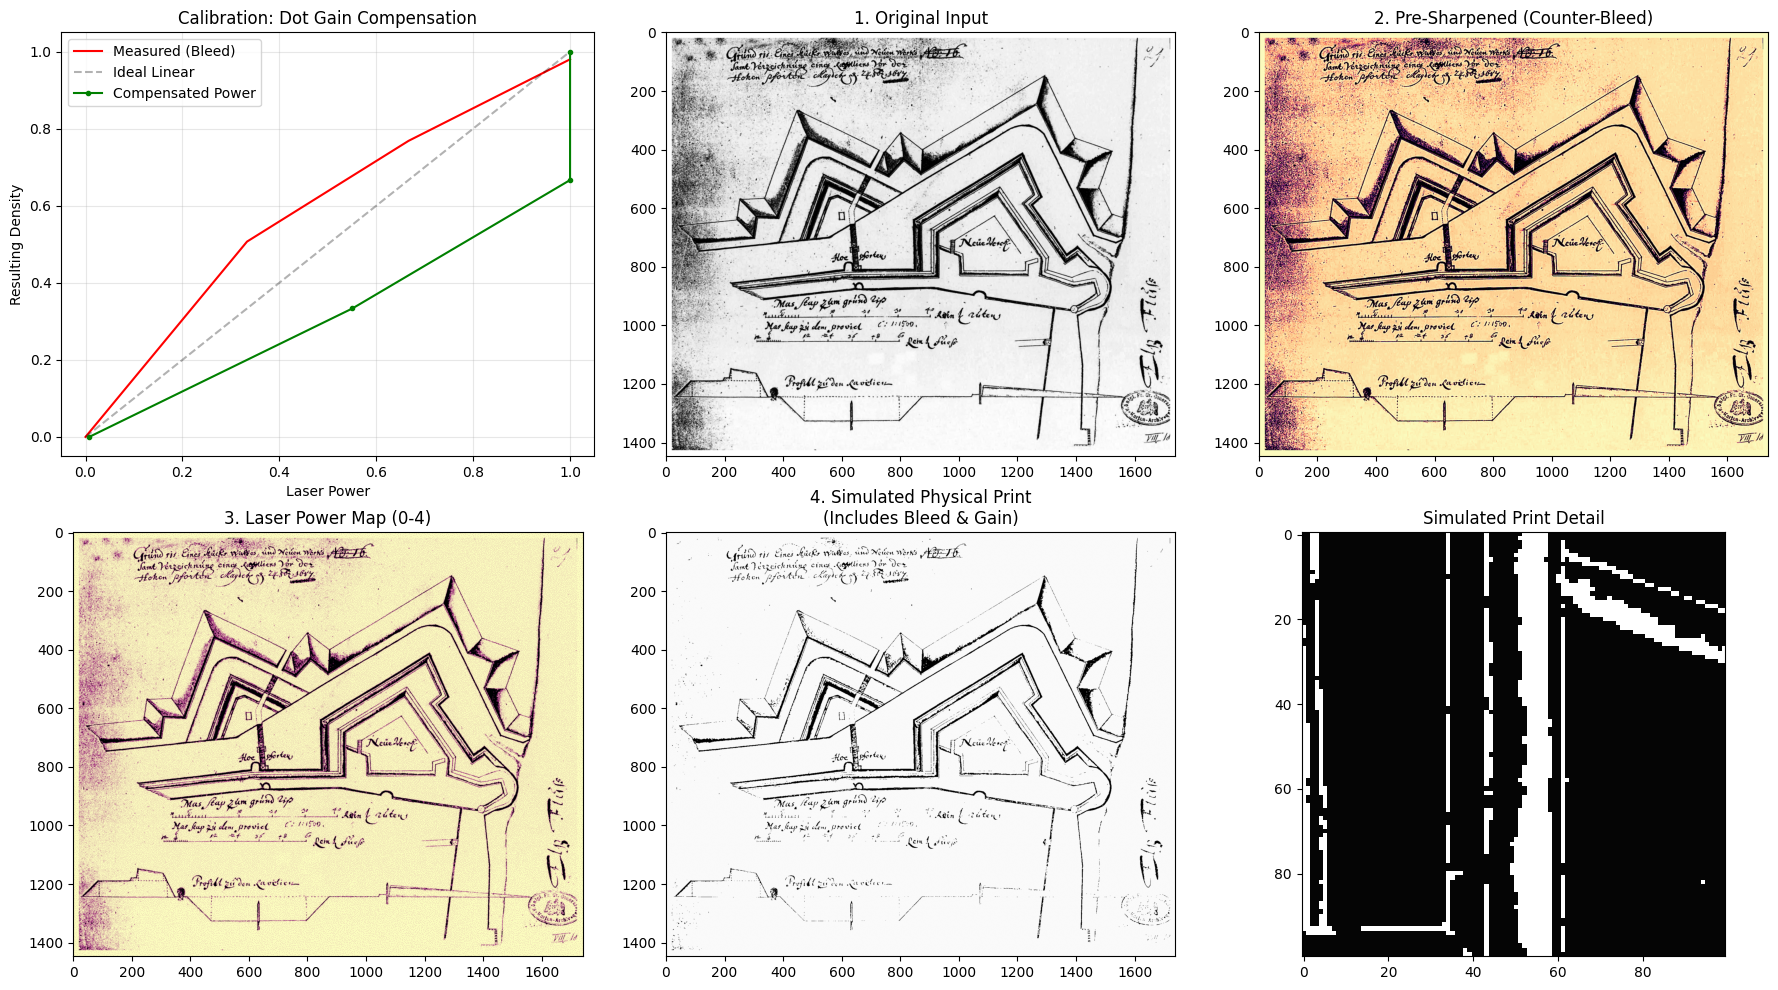

------------------------------
File saved: laser_sim.png
Stats:
  Configuration Steps: 4 (0-74)
  Original Map Range:  0 to 74
  Saved PNG Range:     0 to 74
------------------------------


In [ ]:
# ==========================================
# 6. Visualization (Simulating the Print)
# ==========================================

# 1. Map commands back to "Expected Physical Density" using the raw curve
# This shows what will actually appear on the paper
simulated_print_density = np.interp(
    laser_command_map / (LASER_STEPS-1), # x-coord (commanded power 0-1)
    raw_power,                             # x-ref
    raw_density                            # y-ref (result density)
)

# 2. Simulate spatial bleed (blur) 
# This mimics the "point bleeds out" effect physically happening on paper
from scipy.ndimage import gaussian_filter
simulated_print_physical = gaussian_filter(simulated_print_density, sigma=0)

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Top Left: The Calibration Curve
ax[0,0].plot(raw_power, raw_density, 'r-', label='Measured (Bleed)')
ax[0,0].plot(np.linspace(0,1,LASER_STEPS), np.linspace(0,1,LASER_STEPS), 'k--', alpha=0.3, label='Ideal Linear')
ax[0,0].plot(1-compensated_lut_vals, np.linspace(0,1,LASER_STEPS), 'g.-', label='Compensated Power')
ax[0,0].set_title("Calibration: Dot Gain Compensation")
ax[0,0].set_xlabel("Laser Power")
ax[0,0].set_ylabel("Resulting Density")
ax[0,0].legend()
ax[0,0].grid(True, alpha=0.3)

# Top Middle: Input
ax[0,1].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
ax[0,1].set_title("1. Original Input")

# Top Right: Sharpened Input
ax[0,2].imshow(img_sharpened, cmap='magma', vmin=0, vmax=1)
ax[0,2].set_title("2. Pre-Sharpened (Counter-Bleed)")

# Bottom Left: The Laser Command Map (What you send to machine)
# Note: It usually looks 'lighter' than the image to account for darkening bleed
ax[1,0].imshow(laser_command_map, cmap='magma') 
ax[1,0].set_title(f"3. Laser Power Map (0-{LASER_STEPS})")

# Bottom Middle: Simulated Result
# Note: We invert cmap because in Density, 1=Dark
ax[1,1].imshow(simulated_print_physical, cmap='gray', vmin=0, vmax=1)
ax[1,1].set_title("4. Simulated Physical Print\n(Includes Bleed & Gain)")

# Bottom Right: Detail Zoom
h, w = laser_command_map.shape
zoom = simulated_print_physical[h//2:h//2+100, w//2:w//2+100]
ax[1,2].imshow(1 - zoom, cmap='gray', vmin=0, vmax=1)
ax[1,2].set_title("Simulated Print Detail")

plt.tight_layout()
plt.show()

extent = ax[1,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('laser_power_map.png', bbox_inches=extent, dpi=300)

extent = ax[1,1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('out_sim.png', bbox_inches=extent, dpi=300)

# ==========================================
# 7. Output to PNG
# ==========================================

# Define the maximum possible step index (e.g., 80 steps means indices 0-79)

max_step_index = MAX_LASERPOWER - 1

# 1. Reverse the values
# Logic: Output = Max_Possible_Value - Current_Value
# Result: 79 becomes 0, 0 becomes 79
inverted_map = max_step_index - laser_command_map

# 2. Convert to 8-bit Unsigned Integer
# constraint: "dont scale the values"
# We simply cast the 0-79 float/int range into uint8. 
# The resulting image will look very dark on a standard monitor (values 0-79 out of 255),
# but the data values will be the exact steps required.
final_output_array = inverted_map.astype(np.uint8)

# 3. Save as Grayscale PNG
output_filename = "laser_map_inverted.png"
output_image = Image.fromarray(final_output_array, mode='L')
output_image.save(output_filename, dpi=(TARGET_DPI, TARGET_DPI))

final_norm_output_array = laser_command_map.astype(np.uint8)
output_filename = "laser_map.png"
output_image = Image.fromarray(final_norm_output_array, mode='L')
output_image.save(output_filename, dpi=(TARGET_DPI, TARGET_DPI))

final_norm_output_array = simulated_print_density
output_filename = "laser_sim.png"
output_image = Image.fromarray((final_norm_output_array*255).astype(np.uint8), mode='L')
output_image.save(output_filename, dpi=(TARGET_DPI, TARGET_DPI))

print("-" * 30)
print(f"File saved: {output_filename}")
print(f"Stats:")
print(f"  Configuration Steps: {LASER_STEPS} (0-{max_step_index})")
print(f"  Original Map Range:  {laser_command_map.min()} to {laser_command_map.max()}")
print(f"  Saved PNG Range:     {final_output_array.min()} to {final_output_array.max()}")
print("-" * 30)

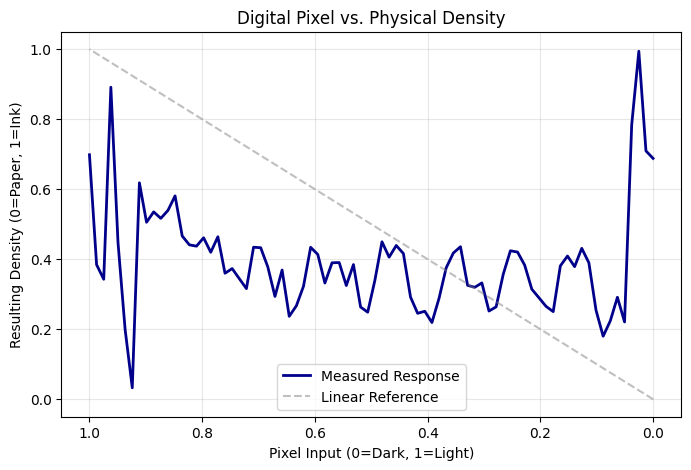

In [237]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# 1. SETUP & DATA LOADING
# ---------------------------------------------------------
# Replace 'your_data.csv' with your actual file path
df = pd.read_csv("correction_lut.csv")

# ---------------------------------------------------------

def process_and_get_interpolator(dataframe):
    """
    Normalizes CSV data and returns a callable interpolation function.
    """
    # 1. Sort by input_val to ensure interpolation works correctly
    df_sorted = dataframe.sort_values(by='input_val')
    
    x_raw = df_sorted['input_val'].values
    y_raw = df_sorted['measured_intensity'].values

    # 2. Normalize Pixel Input to 0-1
    # 0.0 = Black Pixel, 1.0 = White Pixel
    x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())

    # 3. Normalize Measured Density to 0-1
    # 0.0 = Paper White (Minimum measured value)
    # 1.0 = Darkest Blue (Maximum measured value)
    y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

    # 4. Create Interpolator
    # This maps the Digital Pixel (0-1) to the Physical Density (0-1)
    return interp1d(x_norm, y_norm, kind='linear', fill_value="extrapolate")

# Initialize the interpolator globally
curve_interpolator = process_and_get_interpolator(df)

# 2. THE UPDATED FUNCTION
# ---------------------------------------------------------
def get_measured_curve(steps):
    """
    Simulates the response curve based on measured CSV data.
    
    X-axis: Digital Pixel Value (normalized 0=Black, 1=White)
    Y-axis: Resulting Print Density (0=Paper White, 1=Darkest Blue)
    """
    # Create inputs representing pixels from 0 (Black) to 1 (White)
    pixel_input = np.linspace(0, 1, steps)
    
    # Get the density that physically occurred for these pixels
    resulting_density = curve_interpolator(pixel_input)
    
    # Clip values to stay strictly within 0.0 - 1.0 range
    resulting_density = np.clip(resulting_density, 0, 1)
    
    return pixel_input, resulting_density

# 3. VERIFICATION PLOT
# ---------------------------------------------------------
pixels, density = get_measured_curve(80)

plt.figure(figsize=(8, 5))
plt.plot(pixels, density, label='Measured Response', color='darkblue', linewidth=2)
plt.plot(pixels, pixels, '--', color='gray', label='Linear Reference', alpha=0.5)

# Naming the axes as requested
plt.title("Digital Pixel vs. Physical Density")
plt.xlabel("Pixel Input (0=Dark, 1=Light)")
plt.ylabel("Resulting Density (0=Paper, 1=Ink)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis() # Optional: Visually puts Black (0) on the left
plt.show()